In [2]:
import pandas as pd

df = pd.read_csv("df.csv")

# Drop useless / constant columns
df = df.drop(columns=[
    "EmployeeNumber",
    "EmployeeCount",
    "StandardHours",
    "Over18"
])


In [3]:
X = df.drop(columns=["Attrition"])
y = df["Attrition"].map({"Yes": 1, "No": 0})


In [4]:
df.head()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EnvironmentSatisfaction,Gender,...,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,2,Female,...,3,1,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,3,Male,...,4,4,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,4,Male,...,3,2,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,4,Female,...,3,3,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,Male,...,3,4,1,6,3,3,2,2,2,2


In [5]:
cat_features = [
    "BusinessTravel",
    "Department",
    "EducationField",
    "Gender",
    "JobRole",
    "MaritalStatus",
    "OverTime"
]
num_features = [
    "Age",
    "DailyRate",
    "DistanceFromHome",
    "Education",
    "EnvironmentSatisfaction",
    "HourlyRate",
    "JobInvolvement",
    "JobLevel",
    "JobSatisfaction",
    "MonthlyIncome",
    "MonthlyRate",
    "NumCompaniesWorked",
    "PercentSalaryHike",
    "PerformanceRating",
    "RelationshipSatisfaction",
    "StockOptionLevel",
    "TotalWorkingYears",
    "TrainingTimesLastYear",
    "WorkLifeBalance",
    "YearsAtCompany",
    "YearsInCurrentRole",
    "YearsSinceLastPromotion",
    "YearsWithCurrManager"
]


In [6]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline


numeric_transformer = Pipeline(steps=[
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_features),
        ("cat", categorical_transformer, cat_features)
    ]
)


In [7]:
from sklearn.linear_model import LogisticRegression

model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", LogisticRegression(
        max_iter=2000,
        class_weight="balanced",
        solver="liblinear"
    ))
])


In [8]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)


In [9]:
from sklearn.metrics import classification_report, roc_auc_score

model.fit(X_train, y_train)

y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_prob))


              precision    recall  f1-score   support

           0       0.92      0.77      0.84       247
           1       0.35      0.64      0.45        47

    accuracy                           0.75       294
   macro avg       0.63      0.71      0.65       294
weighted avg       0.83      0.75      0.78       294

ROC-AUC: 0.8029115341545353


In [10]:
threshold = 0.4
y_pred_custom = (y_prob >= threshold).astype(int)
print(classification_report(y_test, y_pred_custom))


              precision    recall  f1-score   support

           0       0.95      0.72      0.82       247
           1       0.35      0.79      0.48        47

    accuracy                           0.73       294
   macro avg       0.65      0.75      0.65       294
weighted avg       0.85      0.73      0.76       294



In [11]:
import numpy as np

feature_names = (
    model.named_steps["preprocessor"]
         .get_feature_names_out()
)

coefs = model.named_steps["classifier"].coef_[0]

importance = (
    pd.DataFrame({
        "feature": feature_names,
        "coef": coefs
    })
    .sort_values("coef", ascending=False)
)

importance.head(35)


,feature,coef
39,cat__JobRole_Laboratory Technician,1.190786
45,cat__JobRole_Sales Representative,1.087935
24,cat__BusinessTravel_Travel_Frequently,0.757030
29,cat__EducationField_Human Resources,0.718492
50,cat__OverTime_Yes,0.718069
7,num__JobLevel,0.602700
21,num__YearsSinceLastPromotion,0.502860
11,num__NumCompaniesWorked,0.460414
38,cat__JobRole_Human Resources,0.433866
48,cat__MaritalStatus_Single,0.428363


In [12]:
importance["abs_coef"] = importance["coef"].abs()
importance.sort_values("abs_coef", ascending=False).head(35)


,feature,coef,abs_coef
42,cat__JobRole_Research Director,-1.451607,1.451607
39,cat__JobRole_Laboratory Technician,1.190786,1.190786
45,cat__JobRole_Sales Representative,1.087935,1.087935
23,cat__BusinessTravel_Non-Travel,-1.020899,1.020899
49,cat__OverTime_No,-0.936726,0.936726
33,cat__EducationField_Other,-0.813162,0.813162
24,cat__BusinessTravel_Travel_Frequently,0.757030,0.757030
29,cat__EducationField_Human Resources,0.718492,0.718492
50,cat__OverTime_Yes,0.718069,0.718069
37,cat__JobRole_Healthcare Representative,-0.648861,0.648861


In [13]:
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, roc_auc_score


In [14]:
xgb = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", XGBClassifier(
        n_estimators=300,
        max_depth=4,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        objective="binary:logistic",
        eval_metric="auc",
        scale_pos_weight=(y_train.value_counts()[0] / y_train.value_counts()[1]),
        random_state=42
    ))
])


In [15]:
xgb.fit(X_train, y_train)

y_pred = xgb.predict(X_test)
y_prob = xgb.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_prob))


              precision    recall  f1-score   support

           0       0.89      0.93      0.91       247
           1       0.50      0.38      0.43        47

    accuracy                           0.84       294
   macro avg       0.69      0.66      0.67       294
weighted avg       0.83      0.84      0.83       294

ROC-AUC: 0.7769833749676975


In [16]:
threshold = 0.4
y_pred_custom = (y_prob >= threshold).astype(int)
print(classification_report(y_test, y_pred_custom))


              precision    recall  f1-score   support

           0       0.90      0.89      0.89       247
           1       0.44      0.47      0.45        47

    accuracy                           0.82       294
   macro avg       0.67      0.68      0.67       294
weighted avg       0.82      0.82      0.82       294



In [17]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline

rf = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", RandomForestClassifier(
        n_estimators=600,
        max_depth=8,              # shallow
        min_samples_leaf=30,      # VERY important
        min_samples_split=50,
        class_weight={0: 1, 1: 3},  # force attrition attention
        random_state=42,
        n_jobs=-1
    ))
])


In [18]:
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)
y_prob = rf.predict_proba(X_test)[:, 1]

from sklearn.metrics import classification_report, roc_auc_score
print(classification_report(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_prob))


              precision    recall  f1-score   support

           0       0.89      0.92      0.90       247
           1       0.47      0.38      0.42        47

    accuracy                           0.83       294
   macro avg       0.68      0.65      0.66       294
weighted avg       0.82      0.83      0.83       294

ROC-AUC: 0.7809458178999051


In [19]:
threshold = 0.35
y_pred_custom = (y_prob >= threshold).astype(int)

print(classification_report(y_test, y_pred_custom))


              precision    recall  f1-score   support

           0       0.94      0.75      0.84       247
           1       0.36      0.74      0.49        47

    accuracy                           0.75       294
   macro avg       0.65      0.75      0.66       294
weighted avg       0.85      0.75      0.78       294



In [20]:
import numpy as np
from sklearn.metrics import classification_report

thresholds = np.arange(0.2, 0.61, 0.05)

results = []

for t in thresholds:
    y_pred_t = (y_prob >= t).astype(int)
    report = classification_report(
        y_test, y_pred_t, output_dict=True
    )
    results.append({
        "threshold": t,
        "recall_1": report["1"]["recall"],
        "precision_1": report["1"]["precision"],
        "f1_1": report["1"]["f1-score"],
        "accuracy": report["accuracy"]
    })

import pandas as pd
pd.DataFrame(results)


,threshold,recall_1,precision_1,f1_1,accuracy
0,0.20,0.914894,0.188596,0.312727,0.357143
1,0.25,0.893617,0.233333,0.370044,0.513605
2,0.30,0.829787,0.317073,0.458824,0.687075
3,0.35,0.744681,0.364583,0.489510,0.751701
4,0.40,0.638298,0.422535,0.508475,0.802721
5,0.45,0.553191,0.448276,0.495238,0.819728
6,0.50,0.382979,0.473684,0.423529,0.833333
7,0.55,0.212766,0.384615,0.273973,0.819728
8,0.60,0.148936,0.368421,0.212121,0.823129


In [21]:
df.columns

Index(['Age', 'Attrition', 'BusinessTravel', 'DailyRate', 'Department',
       'DistanceFromHome', 'Education', 'EducationField',
       'EnvironmentSatisfaction', 'Gender', 'HourlyRate', 'JobInvolvement',
       'JobLevel', 'JobRole', 'JobSatisfaction', 'MaritalStatus',
       'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked', 'OverTime',
       'PercentSalaryHike', 'PerformanceRating', 'RelationshipSatisfaction',
       'StockOptionLevel', 'TotalWorkingYears', 'TrainingTimesLastYear',
       'WorkLifeBalance', 'YearsAtCompany', 'YearsInCurrentRole',
       'YearsSinceLastPromotion', 'YearsWithCurrManager'],
      dtype='object')

Without Survey Features


In [22]:
y = df["Attrition"].map({"Yes": 1, "No": 0})


In [23]:
num_features = [
    "Age",
    "DailyRate",
    "DistanceFromHome",
    "Education",
    "HourlyRate",
    "JobLevel",
    "MonthlyIncome",
    "MonthlyRate",
    "NumCompaniesWorked",
    "PercentSalaryHike",
    "PerformanceRating",
    "StockOptionLevel",
    "TotalWorkingYears",
    "TrainingTimesLastYear",
    "YearsAtCompany",
    "YearsInCurrentRole",
    "YearsSinceLastPromotion",
    "YearsWithCurrManager"
]

cat_features = [
    "BusinessTravel",
    "Department",
    "EducationField",
    "Gender",
    "JobRole",
    "MaritalStatus",
    "OverTime"
]


In [24]:
X = df[num_features + cat_features]


In [25]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder


numeric_transformer = Pipeline([
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline([
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

preprocessor = ColumnTransformer([
    ("num", numeric_transformer, num_features),
    ("cat", categorical_transformer, cat_features)
])

from sklearn.linear_model import LogisticRegression
model_practical = Pipeline([
    ("preprocessor", preprocessor),
    ("classifier", LogisticRegression(
        max_iter=2000,
        class_weight="balanced",
        solver="liblinear"
    ))
])


from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

model_practical.fit(X_train, y_train)

y_prob_practical = model_practical.predict_proba(X_test)[:, 1]


In [26]:
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report

thresholds = np.arange(0.2, 0.61, 0.05)

rows = []
for t in thresholds:
    y_pred_t = (y_prob_practical >= t).astype(int)
    report = classification_report(
        y_test, y_pred_t, output_dict=True
    )
    rows.append({
        "threshold": t,
        "recall_1": report["1"]["recall"],
        "precision_1": report["1"]["precision"],
        "f1_1": report["1"]["f1-score"],
        "accuracy": report["accuracy"]
    })

pd.DataFrame(rows)


,threshold,recall_1,precision_1,f1_1,accuracy
0,0.20,0.851064,0.217391,0.346320,0.486395
1,0.25,0.829787,0.233533,0.364486,0.537415
2,0.30,0.723404,0.242857,0.363636,0.595238
3,0.35,0.723404,0.263566,0.386364,0.632653
4,0.40,0.702128,0.289474,0.409938,0.676871
5,0.45,0.659574,0.329787,0.439716,0.731293
6,0.50,0.659574,0.352273,0.459259,0.751701
7,0.55,0.617021,0.371795,0.464000,0.772109
8,0.60,0.574468,0.402985,0.473684,0.795918


In [27]:
# ===============================
# PRACTICAL-CLEAN IBM ATTRITION MODEL
# (MonthlyIncome only, no surveys)
# ===============================

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score

# -------------------------------
# 1. Target
# -------------------------------
y = df["Attrition"].map({"Yes": 1, "No": 0})

# -------------------------------
# 2. Feature selection
# -------------------------------

# Numerical features (KEEP MonthlyIncome only from compensation)
num_features = [
    "Age",
    "DistanceFromHome",
    "Education",
    "JobLevel",
    "MonthlyIncome",
    "NumCompaniesWorked",
    "PercentSalaryHike",
    "PerformanceRating",
    "StockOptionLevel",
    "TotalWorkingYears",
    "TrainingTimesLastYear",
    "YearsAtCompany",
    "YearsInCurrentRole",
    "YearsSinceLastPromotion",
    "YearsWithCurrManager"
]

# Categorical features (practical)
cat_features = [
    "BusinessTravel",
    "Department",
    "EducationField",
    "Gender",
    "JobRole",
    "MaritalStatus",
    "OverTime"
]

X = df[num_features + cat_features]

# -------------------------------
# 3. Train / Test split
# -------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

# -------------------------------
# 4. Preprocessing
# -------------------------------
numeric_transformer = Pipeline([
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline([
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

preprocessor = ColumnTransformer([
    ("num", numeric_transformer, num_features),
    ("cat", categorical_transformer, cat_features)
])

# -------------------------------
# 5. Model
# -------------------------------
model = Pipeline([
    ("preprocessor", preprocessor),
    ("classifier", LogisticRegression(
        max_iter=2000,
        class_weight="balanced",
        solver="liblinear"
    ))
])

# -------------------------------
# 6. Train
# -------------------------------
model.fit(X_train, y_train)

# -------------------------------
# 7. Evaluate (probabilities)
# -------------------------------
y_prob = model.predict_proba(X_test)[:, 1]
print("ROC-AUC:", roc_auc_score(y_test, y_prob))

# -------------------------------
# 8. Threshold sweep
# -------------------------------
thresholds = np.arange(0.2, 0.61, 0.05)
rows = []

for t in thresholds:
    y_pred_t = (y_prob >= t).astype(int)
    report = classification_report(y_test, y_pred_t, output_dict=True)
    rows.append({
        "threshold": t,
        "recall_1": report["1"]["recall"],
        "precision_1": report["1"]["precision"],
        "f1_1": report["1"]["f1-score"],
        "accuracy": report["accuracy"]
    })

pd.DataFrame(rows)


ROC-AUC: 0.7710397105693858


,threshold,recall_1,precision_1,f1_1,accuracy
0,0.20,0.872340,0.211340,0.340249,0.459184
1,0.25,0.829787,0.226744,0.356164,0.520408
2,0.30,0.829787,0.261745,0.397959,0.598639
3,0.35,0.765957,0.276923,0.406780,0.642857
4,0.40,0.702128,0.305556,0.425806,0.697279
5,0.45,0.659574,0.326316,0.436620,0.727891
6,0.50,0.617021,0.333333,0.432836,0.741497
7,0.55,0.595745,0.363636,0.451613,0.768707
8,0.60,0.595745,0.417910,0.491228,0.802721


In [28]:
X_train.columns

Index(['Age', 'DistanceFromHome', 'Education', 'JobLevel', 'MonthlyIncome',
       'NumCompaniesWorked', 'PercentSalaryHike', 'PerformanceRating',
       'StockOptionLevel', 'TotalWorkingYears', 'TrainingTimesLastYear',
       'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion',
       'YearsWithCurrManager', 'BusinessTravel', 'Department',
       'EducationField', 'Gender', 'JobRole', 'MaritalStatus', 'OverTime'],
      dtype='object')

In [29]:
X_train.head()

,Age,DistanceFromHome,Education,JobLevel,MonthlyIncome,NumCompaniesWorked,PercentSalaryHike,PerformanceRating,StockOptionLevel,TotalWorkingYears,...,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,BusinessTravel,Department,EducationField,Gender,JobRole,MaritalStatus,OverTime
1194,47,2,4,4,15972,6,14,3,3,29,...,2,1,2,Travel_Rarely,Sales,Life Sciences,Female,Manager,Divorced,No
128,22,2,1,1,2523,0,14,3,1,3,...,1,2,1,Travel_Rarely,Research & Development,Technical Degree,Male,Laboratory Technician,Married,No
810,46,3,1,4,17465,3,12,3,1,23,...,9,4,9,Travel_Rarely,Sales,Marketing,Male,Manager,Married,No
478,25,13,1,1,2096,1,11,3,0,7,...,4,0,6,Travel_Rarely,Sales,Medical,Male,Sales Representative,Married,No
491,43,9,5,2,5679,3,13,3,1,10,...,7,4,7,Travel_Frequently,Research & Development,Medical,Male,Laboratory Technician,Divorced,Yes


In [30]:
import joblib

joblib.dump(model, "attrition_model.pkl")


['attrition_model.pkl']

In [31]:
categorical_columns = [
    "BusinessTravel",
    "Department",
    "EducationField",
    "Gender",
    "JobRole",
    "MaritalStatus",
    "OverTime"
]
category_values = {}

for col in categorical_columns:
    category_values[col] = sorted(X_train[col].dropna().unique().tolist())

category_values


{'BusinessTravel': ['Non-Travel', 'Travel_Frequently', 'Travel_Rarely'],
 'Department': ['Human Resources', 'Research & Development', 'Sales'],
 'EducationField': ['Human Resources',
  'Life Sciences',
  'Marketing',
  'Medical',
  'Other',
  'Technical Degree'],
 'Gender': ['Female', 'Male'],
 'JobRole': ['Healthcare Representative',
  'Human Resources',
  'Laboratory Technician',
  'Manager',
  'Manufacturing Director',
  'Research Director',
  'Research Scientist',
  'Sales Executive',
  'Sales Representative'],
 'MaritalStatus': ['Divorced', 'Married', 'Single'],
 'OverTime': ['No', 'Yes']}

In [32]:
# =====================================================
# TIER 1 ATTRITION MODEL (CORE HRMS FEATURES ONLY)
# =====================================================

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score

# -----------------------------------------------------
# 1. TARGET
# -----------------------------------------------------
y = df["Attrition"].map({"Yes": 1, "No": 0})

# -----------------------------------------------------
# 2. TIER 1 FEATURE SET
# -----------------------------------------------------

num_features = [
    "Age",
    "DistanceFromHome",
    "JobLevel",
    "MonthlyIncome",
    "NumCompaniesWorked",
    "TotalWorkingYears",
    "YearsAtCompany",
    "YearsInCurrentRole",
    "YearsSinceLastPromotion",
    "YearsWithCurrManager"
]

cat_features = [
    "Department",
    "JobRole",
    "Gender",
    "MaritalStatus",
    "OverTime"
]

X = df[num_features + cat_features]

# -----------------------------------------------------
# 3. TRAIN / TEST SPLIT
# -----------------------------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

# -----------------------------------------------------
# 4. PREPROCESSING
# -----------------------------------------------------
numeric_transformer = Pipeline([
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline([
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

preprocessor = ColumnTransformer([
    ("num", numeric_transformer, num_features),
    ("cat", categorical_transformer, cat_features)
])

# -----------------------------------------------------
# 5. MODEL
# -----------------------------------------------------
model_tier1 = Pipeline([
    ("preprocessor", preprocessor),
    ("classifier", LogisticRegression(
        max_iter=2000,
        class_weight="balanced",
        solver="liblinear"
    ))
])

# -----------------------------------------------------
# 6. TRAIN
# -----------------------------------------------------
model_tier1.fit(X_train, y_train)

# -----------------------------------------------------
# 7. BASE EVALUATION
# -----------------------------------------------------
y_prob = model_tier1.predict_proba(X_test)[:, 1]

print("ROC-AUC:", roc_auc_score(y_test, y_prob))

# -----------------------------------------------------
# 8. THRESHOLD SWEEP
# -----------------------------------------------------
thresholds = np.arange(0.2, 0.61, 0.05)
rows = []

for t in thresholds:
    y_pred_t = (y_prob >= t).astype(int)
    report = classification_report(
        y_test, y_pred_t, output_dict=True
    )
    rows.append({
        "threshold": t,
        "recall_1": report["1"]["recall"],
        "precision_1": report["1"]["precision"],
        "f1_1": report["1"]["f1-score"],
        "accuracy": report["accuracy"]
    })

tier1_results = pd.DataFrame(rows)
tier1_results


ROC-AUC: 0.7582048410715824


,threshold,recall_1,precision_1,f1_1,accuracy
0,0.20,0.893617,0.200957,0.328125,0.414966
1,0.25,0.808511,0.211111,0.334802,0.486395
2,0.30,0.765957,0.229299,0.352941,0.551020
3,0.35,0.744681,0.250000,0.374332,0.602041
4,0.40,0.744681,0.286885,0.414201,0.663265
5,0.45,0.744681,0.318182,0.445860,0.704082
6,0.50,0.723404,0.361702,0.482270,0.751701
7,0.55,0.638298,0.370370,0.468750,0.768707
8,0.60,0.595745,0.378378,0.462810,0.778912


In [33]:
import joblib

joblib.dump(model_tier1, "attrition_model2.pkl")

['attrition_model2.pkl']

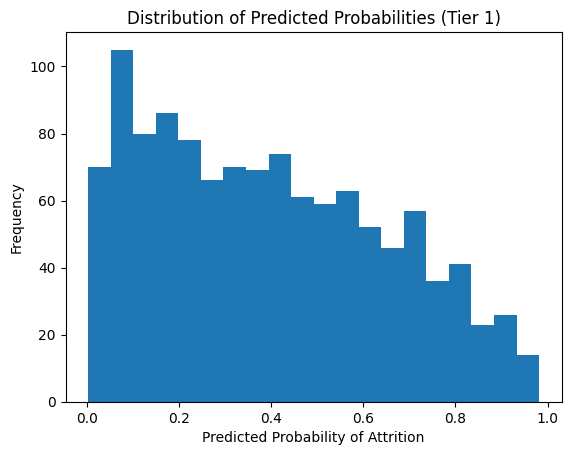

In [39]:
probs = model_tier1.predict_proba(X_train)[:, 1]

plt.hist(probs, bins=20)
plt.xlabel("Predicted Probability of Attrition")
plt.ylabel("Frequency")
plt.title("Distribution of Predicted Probabilities (Tier 1)")
plt.show()


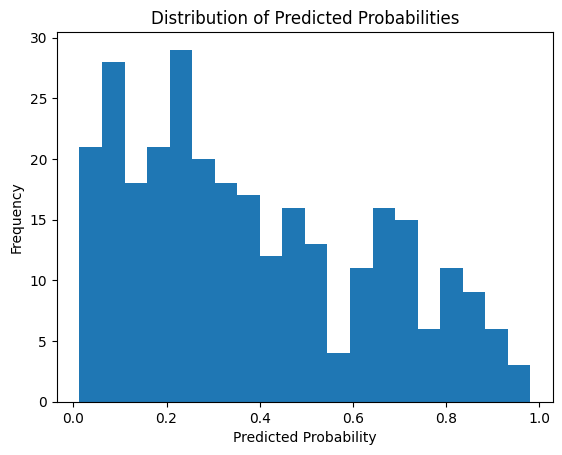

In [38]:
import matplotlib.pyplot as plt

plt.hist(y_prob, bins=20)
plt.xlabel("Predicted Probability")
plt.ylabel("Frequency")
plt.title("Distribution of Predicted Probabilities")
plt.show()
